In [47]:
import numpy as np
import sys
import scipy.stats as st
from pathlib import Path
import pickle

sys.path.append('../..')

from uq.forward import sobol_sa
from surrogates.system import SystemSurrogate

In [3]:
# Load the full SystemSurrogate
save_dir = 'build_2023-07-18T01.48.39'
root_dir = Path('../../surrogates') / save_dir
surr = SystemSurrogate.load_from_file(root_dir / 'sys' / 'sys_final.pkl', root_dir=root_dir)
surr.set_output_dir({'Thruster': None})  # Don't save outputs for testing
qoi_idx = [1, 2, 3]

2023-08-08 09:37:51,928 — [INFO] — surrogates.system.SystemSurrogate    — SystemSurrogate loaded from C:\Users\eckel\Documents\GitHub\HallThrusterPEM\surrogates\build_2023-07-18T01.48.39\sys\sys_final.pkl


In [48]:
# Build a lhc_sampler only over model parameters, ignore default values here
default = {'PB': -5, 'Va': 300, 'mdot_a': 5, 'r_m': 1, 'c0': 0.5, 'c1': 0.3, 'c2': 9.73, 'c3': 0.261, 'c4': 20, 'c5': 16, 'sigma_cex': 55, 'V_vac': 30, 'P*': 2.87, 'PT': 1}
lb, ub, default_idx, sample_idx, labels = [], [], [], [], []
for i, var in enumerate(surr.exo_vars):
    if str(var) not in default:
        lb.append(var.bounds()[0])
        ub.append(var.bounds()[1])
        sample_idx.append(i)
        labels.append(r'${}$'.format(str(var)))
    else:
        default_idx.append(i)

def lhc_sampler(shape):
    N, dim = np.prod(shape), len(surr.exo_vars) - len(default)
    x = st.qmc.LatinHypercube(d=dim).random(n=N)
    x = st.qmc.scale(x, lb, ub).reshape(shape + (dim,))
    return x.astype(np.float32)
def model(x):
    # Wrapper to add default values back into the sample matrix
    samples = np.empty(x.shape[:-1] + (len(surr.exo_vars),), dtype=np.float32)
    for i in default_idx:
        samples[..., i] = default[str(surr.exo_vars[i])]
    samples[..., sample_idx] = x[:]
    return surr(samples)[..., 2, np.newaxis].astype(np.float32)

       QoI      Param    S1_mean     S1_err    ST_mean     ST_err
Thrust (N)     $T_ec$     -0.010      0.009      0.014      0.001
Thrust (N)      $u_n$     -0.034      0.014      0.034      0.002
Thrust (N)      $c_w$      0.017      0.009      0.014      0.001
Thrust (N)      $l_t$      0.020      0.015      0.041      0.003
Thrust (N)     $vAN1$      0.282      0.062      0.760      0.045
Thrust (N)     $vAN2$      0.327      0.061      0.759      0.042
Thrust (N)      $l_c$     -0.006      0.009      0.013      0.001
Thrust (N)       $Ti$      0.000      0.000      0.000      0.000
Thrust (N)       $Tn$      0.000      0.000      0.000      0.000
Thrust (N)       $Tb$      0.000      0.000      0.000      0.000

       QoI            2nd-order    S2_mean     S2_err
Thrust (N)      ($T_ec$, $u_n$)      0.011      0.013
Thrust (N)      ($T_ec$, $c_w$)      0.012      0.013
Thrust (N)      ($T_ec$, $l_t$)      0.011      0.013
Thrust (N)     ($T_ec$, $vAN1$)      0.010      0.013
Thr

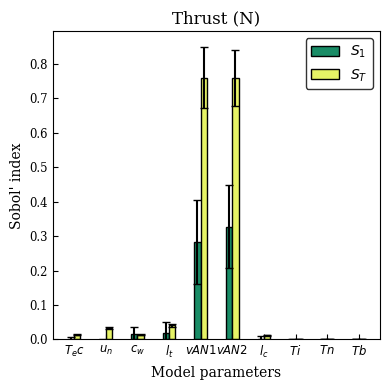

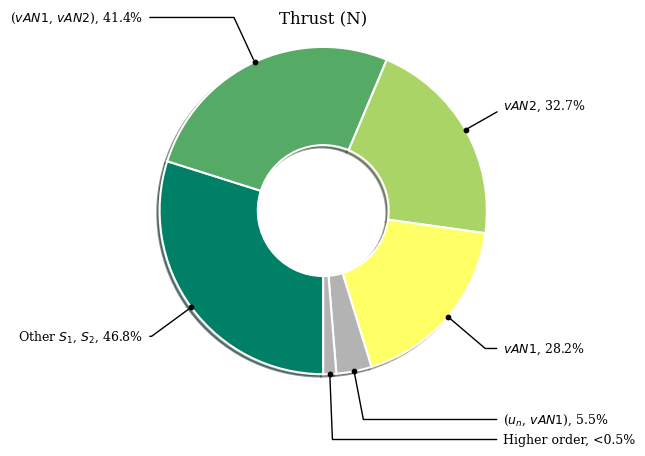

In [49]:
qoi_idx, qois = [0], ['Thrust (N)']
S1, S2, ST = sobol_sa(model, lhc_sampler, 5000, param_labels=labels, qoi_idx=qoi_idx, qoi_labels=qois, cmap='summer')